In [69]:
import numpy as np
import pandas as pd
import glob, os
from itertools import chain, product, permutations
from scipy.stats import pearsonr,ttest_1samp
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
import networkx as nx
np.warnings.filterwarnings('ignore')
%matplotlib inline

### Parse resdisual activity time series into epoch-wise FC matrices (for each participant)

In [2]:
# -------------------
# Helpfer functions
# -------------------
def _separate_epochs(activity_data, epoch_list):
    """ create data epoch by epoch

    Separate data into conditions of interest specified in epoch_list

    Parameters
    ----------
    activity_data: list of 2D array in shape [nVoxels, nTRs]
        the masked activity data organized in voxel*TR formats of all subjects
    epoch_list: list of 3D array in shape [condition, nEpochs, nTRs]
        specification of epochs and conditions
        assuming all subjects have the same number of epochs
        len(epoch_list) equals the number of subjects

    Returns
    -------
    raw_data: list of 2D array in shape [nParcels, timepoints (36*16)]
        the data organized in epochs
        len(raw_data) equals 48 (24 subjects, 2 conditions for each subject for retrieve vs. perceive.)
    labels: list of 1D array
        the condition labels of the epochs
        len(labels) labels equals the number of epochs
    """
    raw_data = []
    labels = []
    for sid in range(len(epoch_list)): #for a given subject
        epoch = epoch_list[sid] # get their npy array
        for cond in range(epoch.shape[0]): # for a given condition
            # for each condition
            sub_epoch = epoch[cond, :, :]
            ts = np.zeros(1956)
            for eid in range(epoch.shape[1]):
                r = np.sum(sub_epoch[eid, :])
                if r > 0:   # there is an epoch in this condition
                    # collapse all epoch of a condition to a single time series
                    ts[sub_epoch[eid, :] == 1] = 1
            ts = ts.astype(np.bool)
            mat_cond = activity_data[sid][:,ts]
            mat_cond = np.ascontiguousarray(mat_cond)
            raw_data.append(mat_cond)
            labels.append(cond)

    return raw_data, labels

def divide_into_epoch(ts, epoch_length): 
    # looping till length l 
    for i in range(0, len(ts), epoch_length):  
        yield ts[i:i + epoch_length] 

# reorganize: 
def reorder_cor_mat(cormat):
    # Original column/row order, this is based on the size of the ROI. 
    roi_order = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
    # New column/row order, this is based on the community structure. 
    new_roi_order = ["mPFC","rAG","Precuneus(Superior)","lAG1","PCC","MTG","lAG2","rITG","rLOC","rPFC","lPFC1","SFG","lPFC2",'lLOC',"Precuenus(Inferior)2","Precuneus(inferior)"]
    
    # turn original np into df
    df = pd.DataFrame(cormat, columns = roi_order, index = roi_order)
   
    new_df =  pd.DataFrame(columns = new_roi_order, index = new_roi_order)
    for row, col in product(new_roi_order, new_roi_order):
        new_df.loc[row, col] = df.loc[row, col] 
        
    new_df = new_df[new_df.columns].astype(float)
    reorder_cormat = new_df.to_numpy()
    return reorder_cormat

# ------------------------------------------------------------------------
# Preprocess data to get bg ts for each subject, condition, epoch, cluster
# ------------------------------------------------------------------------

bg_ts = []
base_dir = '../data/cluster_residual_activity'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key = lambda x: int(x.split('_')[-7]))[0:16]

# epoch files:
ret_per_epoch_list = np.load('../data/epoch_files/perceive_retrieve_epoch_labels.npy')
scramble_ret_epoch_list = np.load('../data/epoch_files/scramble_retrieve_epoch_labels.npy')
scramble_per_epoch_list = np.load('../data/epoch_files/scramble_perceive_epoch_labels.npy')

# list of 2d arrays, each for a cluster. 
ret_subClusterTR, per_subClusterTR, scramble_subClusterTR = [],[],[]
       
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file)
    # preprocess the data;
    
    # ret vs. per
    raw_data_ret_per, labels_ret_per = _separate_epochs(cluster_subVoxTR, ret_per_epoch_list)
    raw_data_ret_per_mean = [np.mean(x, axis = 0) for x in raw_data_ret_per] # average within ROI
    raw_data_ret_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 0)[0].tolist()] # ret bg ts
    raw_data_per_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 1)[0].tolist()] # per bg ts
    
    # scramble vs. ret
    raw_data_scramble_ret, labels_scramble_ret = _separate_epochs(cluster_subVoxTR, scramble_ret_epoch_list)
    raw_data_scramble_ret_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_ret] # average within ROI
    raw_data_scramble_mean = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 0)[0].tolist()] # scramble bg ts
    raw_data_ret_mean2 = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 1)[0].tolist()] # ret bg ts
    
    # scramble vs. per
    raw_data_scramble_per, labels_scramble_per = _separate_epochs(cluster_subVoxTR, scramble_per_epoch_list)
    raw_data_scramble_per_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_per] # average within ROI
    raw_data_scramble_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 0)[0].tolist()] # scramble bg ts
    raw_data_per_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 1)[0].tolist()] # per bg ts
    
    # make sure the duplicated ts are all the same (sanity check)
    check_ret = np.unique([(x == y).all() for x,y in zip(raw_data_ret_mean,raw_data_ret_mean2)])
    check_per = np.unique([(x == y).all() for x,y in zip(raw_data_per_mean,raw_data_per_mean2)])
    check_scramble = np.unique([(x == y).all() for x,y in zip(raw_data_scramble_mean,raw_data_scramble_mean2)])
    
    if check_ret & check_per & check_scramble != True:
        print("Something is wrong")
        break
    
    # devide into ret epoch 
    ret_epoch_ts = []
    per_epoch_ts = []
    scramble_epoch_ts = []
    for sub in range(len(raw_data_ret_mean)): # for each subject
        ret_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_ret_mean[sub], 36)), axis = 0))
        per_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_per_mean[sub], 36)), axis = 0))
        scramble_epoch_ts.append(np.stack(list(divide_into_epoch(raw_data_scramble_mean[sub], 36)), axis = 0))
    
    # for a given cluster
    ret_epoch_ts_np = np.stack(ret_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    per_epoch_ts_np = np.stack(per_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
    scramble_epoch_ts_np = np.stack(scramble_epoch_ts, axis = 0)  #(24sub, 16epoch, 36tr)
      
    # for in a total of 16 clusters    
    ret_subClusterTR.append(ret_epoch_ts_np)
    per_subClusterTR.append(per_epoch_ts_np)
    scramble_subClusterTR.append(scramble_epoch_ts_np)
    
# here the shapes are: (24sub, 16epoch, 16Clusters, 36tr)
ret_subClusterTR_4d = np.stack(ret_subClusterTR, axis = 2)
per_subClusterTR_4d = np.stack(per_subClusterTR, axis = 2)
scramble_subClusterTR_4d = np.stack(scramble_subClusterTR, axis = 2)

# ----------------------------------------
# Compute correlation matrices of needed
# ----------------------------------------

# this will be come 24 (subjects) 16 by 16 corMat
ret_corMat_persub = []
per_corMat_persub = []
scramble_corMat_persub = []
for sub in range(24): 
    # for each subject
    ret_cluster_epoch_cluster_tr = ret_subClusterTR_4d[sub, :,:,:]
    per_cluster_epoch_cluster_tr = per_subClusterTR_4d[sub, :,:,:]
    scramble_cluster_epoch_cluster_tr = scramble_subClusterTR_4d[sub, :,:,:]
    # for each epoch
    ret_sub_cormat = [np.corrcoef(ret_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject retrieve epoch
    per_sub_cormat = [np.corrcoef(per_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject perceive epoch
    scramble_sub_cormat = [np.corrcoef(scramble_cluster_epoch_cluster_tr[epoch, :, :]) for epoch in range(16)] # compute cluster x cluster (16x16) cormat for each subject scramble epoch
    
    # average cormat across 16 epochs
    ret_sub_cormat_mean = np.mean(ret_sub_cormat, axis = 0)
    np.fill_diagonal(ret_sub_cormat_mean, 0)
    per_sub_cormat_mean = np.mean(per_sub_cormat, axis = 0)
    np.fill_diagonal(per_sub_cormat_mean, 0)
    scramble_sub_cormat_mean = np.mean(scramble_sub_cormat, axis = 0)
    np.fill_diagonal(scramble_sub_cormat_mean, 0)
    
    # do this for each subject
    ret_corMat_persub.append(ret_sub_cormat_mean)
    per_corMat_persub.append(per_sub_cormat_mean)
    scramble_corMat_persub.append(scramble_sub_cormat_mean)

# transform to fisherz
ret_corMat_z = [np.arctanh(cormat) for cormat in ret_corMat_persub]
per_corMat_z = [np.arctanh(cormat) for cormat in per_corMat_persub]
scramble_corMat_z = [np.arctanh(cormat) for cormat in scramble_corMat_persub]

# get t value map for the difference between the corMat of the two conditions: 
# Should expect warning due to diagnal NA. 
ret_per_tvalue = ttest_1samp(np.stack([ret - per for ret, per in zip(ret_corMat_z,per_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(ret_per_tvalue, 0)
ret_scramble_tvalue = ttest_1samp(np.stack([ret - scramble for ret, scramble in zip(ret_corMat_z,scramble_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(ret_scramble_tvalue, 0)
scramble_per_tvalue = ttest_1samp(np.stack([scramble - per for scramble, per in zip(scramble_corMat_z,per_corMat_z)], axis = 0), 0, axis = 0)[0]
np.fill_diagonal(scramble_per_tvalue, 0)

# ------------------
# resulted corMats
# ------------------

# difference corMat, averaged across subjects, each entry is a t-value
ret_per_tvalue_reorder = reorder_cor_mat(ret_per_tvalue)
ret_scramble_tvalue_reorder = reorder_cor_mat(ret_scramble_tvalue)
scramble_per_tvalue_reorder = reorder_cor_mat(scramble_per_tvalue)

# conditional corMat, averaged across subjects
ret_corMat_z_reorder = reorder_cor_mat(np.mean(ret_corMat_z, axis = 0))
per_corMat_z_reorder = reorder_cor_mat(np.mean(per_corMat_z, axis = 0))
scramble_corMat_z_reorder = reorder_cor_mat(np.mean(scramble_corMat_z, axis = 0))

# conditional corMat for every subject
ret_corMat_z_reorder_persub = [reorder_cor_mat(ret_corMat_z_sub) for ret_corMat_z_sub in ret_corMat_z]
per_corMat_z_reorder_persub = [reorder_cor_mat(per_corMat_z_sub) for per_corMat_z_sub in per_corMat_z]
scramble_corMat_z_reorder_persub = [reorder_cor_mat(scramble_corMat_z_sub) for scramble_corMat_z_sub in scramble_corMat_z]

### Group-level differences in background FC strengths between each pair of clusters (Figure 4a & 4c)

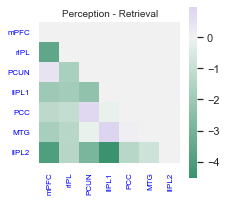

In [79]:
cm = 1/2.54 
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
# ---------------------------------------------
# Commpute Perception - Retrieval FC matrix 
# ---------------------------------------------
perception = [(scr + per)/2 for scr, per in zip(scramble_corMat_z_reorder_persub, per_corMat_z_reorder_persub)] 
retrieval = ret_corMat_z_reorder_persub
# group-level t-test for each cluster-pair
per_ret = ttest_1samp(np.stack([ext - inter for ext, inter in zip(perception,retrieval)], axis = 0), 0, axis = 0)[0]
per_ret_pvalue = ttest_1samp(np.stack([ext - inter for ext, inter in zip(perception,retrieval)], axis = 0), 0, axis = 0)[1]
np.fill_diagonal(per_ret, 0)
np.fill_diagonal(per_ret_pvalue, 1)
per_ret_plot = np.tril(per_ret)
per_ret_pvalue_fdr = fdrcorrection(per_ret_pvalue.flatten(), alpha=0.05, method='indep', is_sorted=False)[0]#[0:-1]
per_ret_pvalue_fdr = per_ret_pvalue_fdr.reshape(16,16)

# --------------------------
# Plot per-ret diff for DMN 
# --------------------------
sns.set(style="white");
_,ax = plt.subplots(figsize=(8*cm, 8*cm)); 
#cmap = sns.diverging_palette(220, 10, as_cmap=True);
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
axis_labels = ["mPFC","rIPL","PCUN","lIPL1","PCC","MTG","lIPL2"]
sns.heatmap(per_ret_plot[0:7,0:7], center=0,cmap=cmap,square=True,
            xticklabels=axis_labels,yticklabels=axis_labels);
plt.tick_params(labelsize=8)
plt.title("Perception - Retrieval", fontsize=10)
ax.tick_params(axis="x", colors="blue")
ax.tick_params(axis="y", colors="blue")
#plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=2);

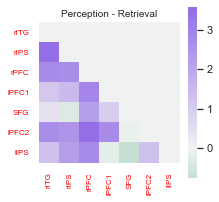

In [80]:
# ------------------------------------------
# Plot per-ret diff for Control network  
# ------------------------------------------
sns.set(style="white");
_,ax = plt.subplots(figsize=(8*cm, 8*cm)); 
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
axis_labels = ["rITG","rIPS","rPFC","lPFC1","SFG","lPFC2","lIPS"]
sns.heatmap(per_ret_plot[7:14,7:14], center=0,cmap=cmap,square=True,
            xticklabels=axis_labels,yticklabels=axis_labels);
plt.tick_params(labelsize=8)
plt.title("Perception - Retrieval", fontsize=10)
ax.tick_params(axis="x", colors="red")
ax.tick_params(axis="y", colors="red")

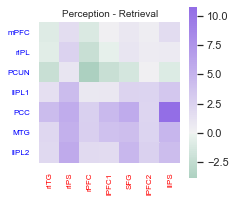

In [81]:
# ------------------------------------------
# Plot per-ret diff for Control-DMN network  
# ------------------------------------------
sns.set(style="white");
_,ax = plt.subplots(figsize=(8*cm, 8*cm)); 
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
yaxis_labels = ["mPFC","rIPL","PCUN","lIPL1","PCC","MTG","lIPL2"]
xaxis_labels = ["rITG","rIPS","rPFC","lPFC1","SFG","lPFC2","lIPS"]
sns.heatmap(per_ret_plot[7:14,0:7], center=0,cmap=cmap,square=True,
            xticklabels=xaxis_labels,yticklabels=yaxis_labels);
plt.tick_params(labelsize=8)
plt.title("Perception - Retrieval", fontsize=10)
ax.tick_params(axis="x", colors="red")
ax.tick_params(axis="y", colors="blue")

### Circos plot for highlighting RSC connectivity patterns (Figure 4E)

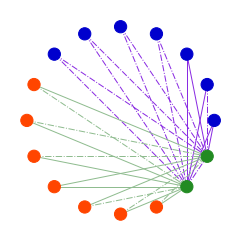

In [84]:
# ------------------------------------
# Function for creating graphs
# ------------------------------------
def create_persub_graph_for_condition(corMat, threshold):
    """
    corMat_list is a list of correaltion matrix 
    """
    
    def _do_single_graph(graph, threshold):
        # Preset the graph
        G = nx.Graph()
        # Create the edge list
        nodelist = []
        edgelist = []
        for row_counter in range(graph.shape[0]):
            nodelist.append(str(row_counter))  # Set up the node names
            for col_counter in range(graph.shape[1]):
                # Determine whether to include the edge based on whether it exceeds the threshold
                if abs(graph[row_counter, col_counter]) > abs(threshold):
                        edgelist.append((str(row_counter), str(col_counter), {'coupling_strength': graph[row_counter, col_counter]}))
                        
        # Create the nodes in the graph
        G.add_nodes_from(nodelist)

        # Add the edges
        G.add_edges_from(edgelist)
        
        nx.set_edge_attributes(G, {e: 1/d["coupling_strength"] for e, d in G.edges.items()}, "distance")
    
        return(G)
        
    if type(corMat) == list: # is a list of corMat
        graph_list = [_do_single_graph(graph, threshold) for graph in corMat]
    else: 
        graph_list = _do_single_graph(corMat, threshold)

    return(graph_list)

# ------------------------------------
# Plot circos plot of RSC FC patterns
# ------------------------------------
per_ret_pvalue_fdr_plot = per_ret_pvalue_fdr[14:16,:].flatten()

# create graphs
per_ret_rsc = per_ret.copy()
per_ret_rsc[0:14, :] = 0
per_ret_rsc_graph = create_persub_graph_for_condition(per_ret_rsc, 0)
pos = nx.circular_layout(per_ret_rsc_graph)

# set edge and weights, color and edge types
edges = per_ret_rsc_graph.edges()
weights = [per_ret_rsc_graph[u][v]['coupling_strength'] for u,v in edges]
edge_colors= np.where(np.array(weights) > 0, 'blueviolet','darkseagreen')
node_colors = np.array(['mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue',
                         'orangered','orangered','orangered','orangered','orangered','orangered','orangered',
                         'forestgreen','forestgreen'])
edge_style = np.where(per_ret_pvalue_fdr_plot, "solid", "-.")

roi_order = {'0': 'mPFC','1': 'rIPL','2': 'PCUN','3': 'lIPL1','4': 'PCC','5': 'MTG','6': 'lIPL2','7': 'rITG','8': 'rIPS',
             '9': 'rPFC','10': 'lPFC1','11': 'SFG','12': 'lPFC2','13': 'lIPS','14': 'RSC2','15': 'RSC1'}

plt.figure(figsize=(8*cm,8*cm)) 
nx.draw(per_ret_rsc_graph, pos, width=1, with_labels = False, node_size = 150, labels = roi_order, style=edge_style,
        font_size=8, edge_color = edge_colors, node_color = node_colors, font_family = 'serif', connectionstyle='arc3,rad=0.2')
plt.tight_layout()
plt.show()


### Make polot plots of each cluster's FC patterns during perception - retrieval

mPFC FC pattern


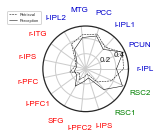

r-IPL FC pattern


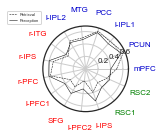

PCUN FC pattern


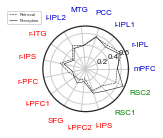

l-IPL1 FC pattern


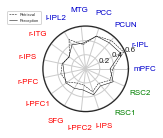

PCC FC pattern


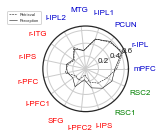

MTG FC pattern


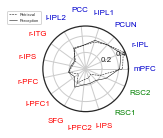

l-IPL2 FC pattern


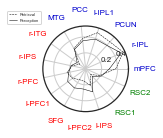

r-ITG FC pattern


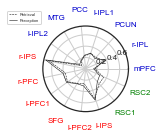

r-IPS FC pattern


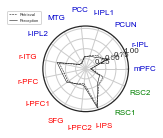

r-PFC FC pattern


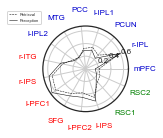

l-PFC1 FC pattern


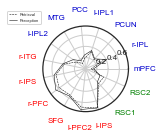

SFG FC pattern


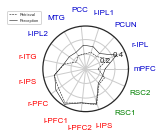

l-PFC2 FC pattern


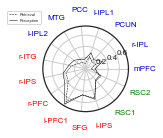

l-IPS FC pattern


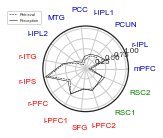

RSC1 FC pattern


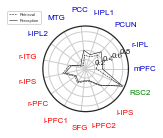

RSC2 FC pattern


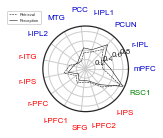

In [101]:
# --------------------------------
# Function for making polar plots
# --------------------------------
def polar_plot(fc_retrieval, fc_perception,  cluster):
    
    all_cluster = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG",
                   "r-IPS", "r-PFC", "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"] # all clusters
    all_color = ['mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue','mediumblue',
                 'red','red','red','red','red','red','red','green','green']
    
    this_cluster_idx = int(np.where(np.array(all_cluster) == cluster)[0]) # which cluster am I looking at 
    all_cluster_update = np.delete(all_cluster, this_cluster_idx) # remove this cluster from all
    #all_cluster_update = np.delete(all_cluster, [14,15]) # remove this cluster from all
    
    fc_retrieval_update = np.delete(np.array(fc_retrieval), this_cluster_idx) # remove the connectivity with itself 
    fc_perception_update = np.delete(np.array(fc_perception), this_cluster_idx) # remove the connectivity with itself 
    
    all_color_update = np.delete(np.array(all_color), this_cluster_idx)
    
    # Initialise the spider plot by setting figure size and polar projection
    figure = plt.figure(figsize=(4*cm, 4*cm))
    ax1 = plt.subplot(polar=True)
    #ax1.set_ylim(0,0.6)
    #ax1.set_yticks(np.arange(0,0.8,0.1))

 
    theta = np.linspace(0,1.86 * np.pi, 15)
 
    # Arrange the grid into number of sales equal parts in degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(all_cluster_update))), (all_cluster_update))
    rlabels = ax1.get_xmajorticklabels()
    for this_label, this_color in zip(rlabels, all_color_update):
        this_label.set_color(this_color)

    # Plot actual sales graph
    plt.plot(np.concatenate([theta, np.array([0])]), 
             np.concatenate([fc_retrieval_update, np.array([fc_retrieval_update[0]])]), linestyle='--', color = 'black', linewidth=0.5)

    plt.plot(np.concatenate([theta, np.array([0])]), 
             np.concatenate([fc_perception_update, np.array([fc_perception_update[0]])]), linestyle='-', color = 'black', linewidth=0.5)
    
    print(f"{cluster} FC pattern")
    plt.tick_params(labelsize=8)
    plt.legend(labels=('Retrieval', 'Perception'), bbox_to_anchor=(0, 1.2), fontsize=4)
    plt.show()

# ---------------------------------------------
# Average FC patterns across participants
# ---------------------------------------------
perception_groupavg = np.mean([scramble_corMat_z_reorder, per_corMat_z_reorder], axis = 0)
retrieval_groupavg = ret_corMat_z_reorder

all_cluster = ["mPFC", "r-IPL", "PCUN", "l-IPL1", "PCC", "MTG", "l-IPL2", "r-ITG",
                   "r-IPS", "r-PFC", "l-PFC1", "SFG", 'l-PFC2', "l-IPS", "RSC1", "RSC2"]
retrieval_avg_fc = ret_corMat_z_reorder

for idx, cluster in enumerate(all_cluster): 
    polar_plot(retrieval_groupavg[idx,:], perception_groupavg[idx,:],  cluster)

### Background FC strengths averaged across all pairwise connectivity within the same functional community across perception and retrieval states (Figure 4b)

In [60]:
def compute_fc_mean(mat, start, end):
    
    dat = np.triu(mat[start:end, start:end]).flatten().tolist()
    dat_nonzero = [x for x in dat if x !=0]
    dat_nonzero_mean = np.mean(dat_nonzero)
    
    return(dat_nonzero_mean)

# --------------------------------------------------------------------------
# Average all pairwise FC strength within the same functional community
# --------------------------------------------------------------------------
deact_density_per, act_density_per = [compute_fc_mean(per, 0, 7) for per in per_corMat_z_reorder_persub], [compute_fc_mean(per, 7, 14) for per in per_corMat_z_reorder_persub]
deact_density_ret, act_density_ret = [compute_fc_mean(ret, 0, 7) for ret in ret_corMat_z_reorder_persub], [compute_fc_mean(ret, 7, 14) for ret in ret_corMat_z_reorder_persub]
deact_density_scramble, act_density_scramble = [compute_fc_mean(scramble, 0, 7) for scramble in scramble_corMat_z_reorder_persub], [compute_fc_mean(scramble, 7, 14) for scramble in scramble_corMat_z_reorder_persub]
rsc_density_per, rsc_density_ret, rsc_density_scramble = [compute_fc_mean(per, 14, 16) for per in per_corMat_z_reorder_persub], [compute_fc_mean(ret, 14, 16) for ret in ret_corMat_z_reorder_persub], [compute_fc_mean(scramble, 14, 16) for scramble in scramble_corMat_z_reorder_persub]

# averaged across perceive and scrmable conditions to get Perception-state measure 
perception = pd.DataFrame({'subject': np.tile(list(range(24)),6),
                         'conn_type': np.tile(np.repeat(["DMN", "Cont", "RSC"], 24),2),
                         'cond_type': np.repeat(["per", "scramble"], 72),
                         'fc_measure': deact_density_per + act_density_per + rsc_density_per + deact_density_scramble + act_density_scramble + rsc_density_scramble})
perception = perception.groupby(['subject','conn_type'])['fc_measure'].mean().reset_index() # average across perceive and scramble conditions
perception['cond_type'] = np.repeat('perception',72)

retrieval = pd.DataFrame({'subject': np.tile(list(range(24)),3),
                         'conn_type': np.tile(np.repeat(["DMN", "Cont", "RSC"], 24),1),
                         'cond_type': np.repeat(["retrieval"], 72),
                         'fc_measure': deact_density_ret + act_density_ret + rsc_density_ret})
within_density = pd.concat([perception, retrieval], sort = False).reset_index()
within_density.to_csv('FCstrengths_results/intra-Net_FCstrenghts.csv', index = False)

# do states: repeated measure anova
print("-----ANOVA (community ~ state)-----")
pg.rm_anova(within_density, dv = "fc_measure", within = ['conn_type', 'cond_type'], subject = "subject")


-----ANOVA (community ~ state)-----


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,conn_type,4.310005,2,46,2.155003,228.561061,1.273332e-24,8.111006e-19,0.908571,0.740145
1,cond_type,0.016768,1,23,0.016768,2.057294,1.649366e-01,1.649366e-01,0.082104,1.000000
2,conn_type * cond_type,0.052289,2,46,0.026144,19.051668,9.391306e-07,1.199122e-05,0.453054,0.766816


In [61]:
print("-----Cont per-ret-----")
pg.ttest(
within_density.loc[(within_density['conn_type'] == "Cont") & (within_density['cond_type'] == "perception"), "fc_measure"].tolist(), 
within_density.loc[(within_density['conn_type'] == "Cont") & (within_density['cond_type'] == "retrieval"), "fc_measure"].tolist(), paired = True)

-----Cont per-ret-----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.264418,23,two-sided,0.033285,"[0.0, 0.06]",0.419488,1.799,0.503633


In [62]:
print("-----RSC per-ret-----")
pg.ttest(
within_density.loc[(within_density['conn_type'] == "RSC") & (within_density['cond_type'] == "perception"), "fc_measure"].tolist(), 
within_density.loc[(within_density['conn_type'] == "RSC") & (within_density['cond_type'] == "retrieval"), "fc_measure"].tolist(), paired = True)

-----RSC per-ret-----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.939969,23,two-sided,0.007354,"[0.02, 0.1]",0.489152,6.274,0.631396


In [63]:
print("-----DMN per-ret-----")
pg.ttest(
within_density.loc[(within_density['conn_type'] == "DMN") & (within_density['cond_type'] == "perception"), "fc_measure"].tolist(), 
within_density.loc[(within_density['conn_type'] == "DMN") & (within_density['cond_type'] == "retrieval"), "fc_measure"].tolist(), paired = True)

-----DMN per-ret-----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.871372,23,two-sided,0.074068,"[-0.06, 0.0]",0.318813,0.958,0.321916


In [64]:
print("-----Cont vs. DMN per-ret-----")
pg.ttest(
within_density[within_density['conn_type'] == "Cont"].groupby('subject').mean().reset_index()['fc_measure'].tolist(),
within_density[within_density['conn_type'] == "DMN"].groupby('subject').mean().reset_index()['fc_measure'].tolist(), paired = True)

-----Cont vs. DMN per-ret-----


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.5368,23,two-sided,0.000012,"[0.05, 0.1]",0.931458,1779.603,0.991927


### Background FC strengths averaged across all pairwise connectivity between RSC clusters and DMN/Control clusters (Figure 4f)


In [65]:
# Averaged FC strengths between RSC clusters and DMN/control clusters
rsc_deact_ret, rsc_act_ret = [np.mean(ret[14:16,0:7]) for ret in ret_corMat_z_reorder_persub], [np.mean(ret[14:16,7:14]) for ret in ret_corMat_z_reorder_persub]
rsc_deact_per, rsc_act_per = [np.mean(per[14:16,0:7]) for per in per_corMat_z_reorder_persub], [np.mean(per[14:16,7:14]) for per in per_corMat_z_reorder_persub]
rsc_deact_scramble, rsc_act_scramble = [np.mean(scramble[14:16,0:7]) for scramble in scramble_corMat_z_reorder_persub], [np.mean(scramble[14:16,7:14]) for scramble in scramble_corMat_z_reorder_persub]

# averaged across perceive and scrmable conditions to get Perception-state measure 
df = pd.DataFrame({'subject': np.tile(list(range(24)),4),
                   'conn_type': np.tile(np.repeat(["rsc_act", "rsc_deact"], 24),2),
                   'cond_type': np.repeat(["scramble", "per"], 48),
                   'fc_measure': rsc_act_scramble + rsc_deact_scramble + rsc_act_per + rsc_deact_per})
perception = df.groupby(['subject','conn_type'])['fc_measure'].mean().reset_index()
perception['cond_type'] = np.repeat('perception',48)

retrieval = pd.DataFrame({'subject': np.tile(list(range(24)),2),
                   'conn_type': np.tile(np.repeat(["rsc_act", "rsc_deact"], 24),1),
                   'cond_type': np.repeat(['retrieval'], 48),
                   'fc_measure': rsc_act_ret + rsc_deact_ret})
between_density = pd.concat([perception, retrieval], sort = False).reset_index()
between_density.to_csv('FCstrengths_results/rsc_ContDMN_FCstrengths.csv', index = False)

print("------ANOVA (community ~ states)------")
print(pg.rm_anova(between_density, dv="fc_measure", within=['cond_type', 'conn_type'], subject="subject"))

------ANOVA (community ~ states)------
                  Source        SS  ddof1  ddof2        MS           F  \
0              cond_type  0.010400      1     23  0.010400    1.475546   
1              conn_type  0.000263      1     23  0.000263    0.067186   
2  cond_type * conn_type  0.105380      1     23  0.105380  106.415349   

          p-unc     p-GG-corr       np2  eps  
0  2.367969e-01  2.367969e-01  0.060287  1.0  
1  7.977845e-01  7.977845e-01  0.002913  1.0  
2  4.238362e-10  4.238362e-10  0.822278  1.0  


In [67]:
print("------RSC-cont during perception vs. retreival------")
pg.ttest(
between_density.loc[(between_density['conn_type'] == "rsc_act") & (between_density['cond_type'] == "perception"), "fc_measure"].tolist(), 
between_density.loc[(between_density['conn_type'] == "rsc_act") & (between_density['cond_type'] == "retrieval"), "fc_measure"].tolist(), paired = True
)

------RSC-cont during perception vs. retreival------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.351019,23,two-sided,0.027664,"[-0.09, -0.01]",0.428362,2.089,0.520213


In [68]:
print("------RSC-dmn during perception vs. retreival------")
pg.ttest(
between_density.loc[(between_density['conn_type'] == "rsc_deact") & (between_density['cond_type'] == "perception"), "fc_measure"].tolist(), 
between_density.loc[(between_density['conn_type'] == "rsc_deact") & (between_density['cond_type'] == "retrieval"), "fc_measure"].tolist(), paired = True
)

------RSC-dmn during perception vs. retreival------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.059849,23,two-sided,0.00004,"[0.05, 0.12]",0.775543,614.422,0.953178
